ALD Regression - 
Anthony DiBenedetto

This program uses a neural network to predict the standard deviation from ALD data. The MAE, MSE, and the R^2 value is caculated and printed out in on the of the bottom cells. Also shown is a graph to display what the actual values of testing standard deviation should look like compared to what is predicted. 

In [1]:
# Import Libraries
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
import torch.onnx
import onnx

In [2]:
# Load the training and test data
training_data = (np.load('ALD_Classification_dataset/training_data.npy'))
training_std = (np.load('ALD_Classification_dataset/training_std.npy'))

testing_data = (np.load('ALD_Classification_dataset/testing_data.npy'))
testing_std = (np.load('ALD_Classification_dataset/testing_std.npy'))

In [3]:
pd.DataFrame(testing_std)

,0
0,0.046884
1,0.001467
2,0.126835
3,0.000956
4,0.003506
...,...
995,0.000653
996,0.036770
997,0.002759
998,0.009343


In [4]:
# Covert dtat is Tensor to float 32
X_train = torch.tensor(training_data.astype(np.float32))
y_train = torch.tensor(training_std.astype(np.float32))

X_test = torch.tensor(testing_data.astype(np.float32))
y_test = torch.tensor(testing_std.astype(np.float32))


In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([10000, 120]),
 torch.Size([1000, 120]),
 torch.Size([10000]),
 torch.Size([1000]))

In [6]:
# Create model
class std(nn.Module):
    def __init__(self, input_features, output_features, hidden_units):
        """ Initialize the model.
        Args:
            input_features (int): number of input features to the model
            output_features (int): number of output features to the model (number output classes)
            hidden_units (int): number of hidden units between layers
        """
        super(std, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.layer_stack(x)


In [7]:
dummy_input = torch.randn(1, 120)

In [8]:
model = std(input_features=120, output_features=1 , hidden_units=480)

model

std(
  (layer_stack): Sequential(
    (0): Linear(in_features=120, out_features=480, bias=True)
    (1): ReLU()
    (2): Linear(in_features=480, out_features=480, bias=True)
    (3): ReLU()
    (4): Linear(in_features=480, out_features=1, bias=True)
  )
)

In [ ]:
# Initialize loss and optimizer 
loss_fn = nn.L1Loss()


optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.0001,
                            momentum=0.9,
                            dampening=.01, 
                            weight_decay=0.0005) 
                            
                            

In [ ]:
torch.manual_seed(42)

# These lists are created for the graph after the model is trained.
epoch_count = []
loss_values = []
test_loss_values = []

# Initialize batch size 
batch_size = 16
num_batches = len(X_train) // batch_size

epochs = 800

for epoch in range(epochs):
    model.train()

    # This will shuffle the training data for each epoch
    indices = torch.randperm(len(X_train))
    X_train = X_train[indices]
    y_train = y_train[indices]

    for i in range(num_batches):
        # Get the current batch
        start = i * batch_size
        end = (i + 1) * batch_size
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]
    
        # Forward pass
        y_pred = model(X_batch)

        # Calculate the loss
        loss = loss_fn(y_pred, y_batch.unsqueeze(1))

        optimizer.zero_grad() 
        
        loss.backward()
        
        optimizer.step()
    
    # Testing
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)       
        
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test.unsqueeze(1))
        if epoch % 50 == 0:
            epoch_count.append(epoch)
            loss_values.append(loss)
            test_loss_values.append(test_loss)
            print(f"Epoch: {epoch} | MAE: {loss.item()} | Test MAE: {test_loss.item()}")

Epoch: 0 | MAE: 0.011353712528944016 | Test MAE: 0.015325168147683144
Epoch: 50 | MAE: 0.004901562817394733 | Test MAE: 0.0052132802084088326
Epoch: 100 | MAE: 0.00600609602406621 | Test MAE: 0.0033330332953482866
Epoch: 150 | MAE: 0.0024443818256258965 | Test MAE: 0.003511267714202404
Epoch: 200 | MAE: 0.0008971417555585504 | Test MAE: 0.002250504679977894
Epoch: 250 | MAE: 0.002052420750260353 | Test MAE: 0.0019231706392019987
Epoch: 300 | MAE: 0.0014185933396220207 | Test MAE: 0.00216570938937366
Epoch: 350 | MAE: 0.0017089354805648327 | Test MAE: 0.0017206385964527726
Epoch: 400 | MAE: 0.001128035713918507 | Test MAE: 0.0017518512904644012
Epoch: 450 | MAE: 0.0013167675351724029 | Test MAE: 0.0018110980745404959
Epoch: 500 | MAE: 0.0014163641026243567 | Test MAE: 0.0019069721456617117
Epoch: 550 | MAE: 0.001124919974245131 | Test MAE: 0.003022471908479929
Epoch: 600 | MAE: 0.0020716460421681404 | Test MAE: 0.001879525021649897
Epoch: 650 | MAE: 0.0011372653534635901 | Test MAE: 0.0

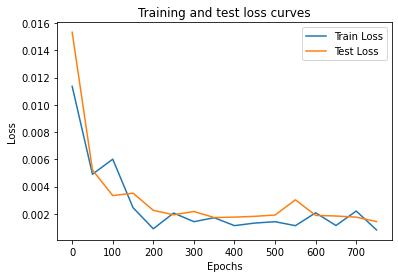

In [ ]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label = "Test Loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

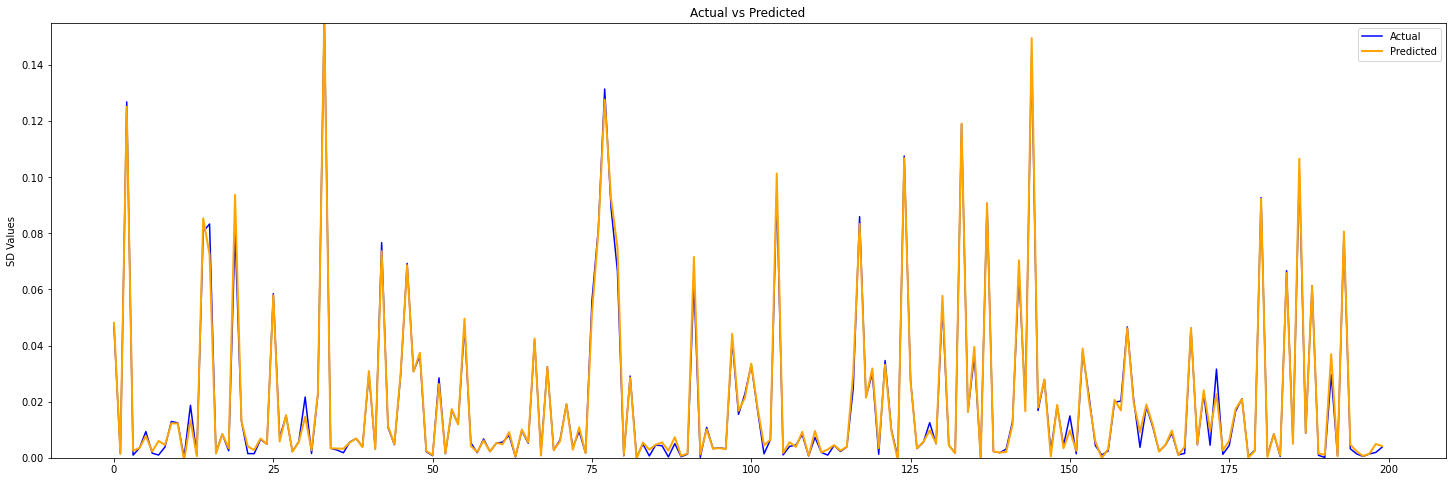

In [ ]:

with torch.inference_mode():
    y_pred = model(X_test)

    # Convert the tensor to a numpy array
    y_pred = y_pred.detach().numpy()

    fig, ax = plt.subplots(figsize=(25,8))

    # Plot the actual values in blue
    ax.plot(y_test[:200], color='blue', label='Actual',linewidth=1.5)

    # Plot the predicted values in orange
    ax.plot(y_pred[:200], color='orange', label='Predicted', linewidth=2)

    # Set the title and legend
    ax.set_title('Actual vs Predicted')
    ax.set_ylabel('SD Values')
    ax.legend()
    ax.set_ylim(0, 0.155)

    # Display the plot
    plt.show()


In [ ]:
import torch.nn.functional as F
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Get the predicted values
with torch.inference_mode():
    
    y_pred = model(X_test)
    
    print("\nMean of y_test: {:.4f}".format(y_test.mean()))
    print("Mean of y_pred: {:.4f}".format(y_pred.mean()))

    print("\nMedian of y_test: {:.4f}".format(y_test.median()))
    print("Median of y_pred: {:.4f}".format(y_pred.median()))

    r_squared = r2_score(y_test.unsqueeze(1), y_pred)
    print("\nR-squared: {}".format(r_squared))

    mse = mean_squared_error(y_test.unsqueeze(1), y_pred)
    print("\nMSE: {}".format(mse))

    mae = mean_absolute_error(y_test.unsqueeze(1), y_pred)
    print("\nMAE: {}".format(mae))

    mean_pred = torch.full_like(y_pred, y_test.mean())
    mean_mae = F.l1_loss(y_test.unsqueeze(1), mean_pred)
    print("Baseline MAE: {:.4f}".format(mean_mae))


Mean of y_test: 0.0217
Mean of y_pred: 0.0219

Median of y_test: 0.0056
Median of y_pred: 0.0060

R-squared: 0.9921759311316882

MSE: 9.0032335720025e-06

MAE: 0.001410006545484066
Baseline MAE: 0.0241


In [ ]:
max(y_test), min(y_test)

(tensor(0.1700), tensor(0.0001))